<a href="https://colab.research.google.com/github/theycomeunstuck/StudyProject_university/blob/main/smallDatasetPytorchUniversity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Установка необходимых модулей для работы (производится единоразово)

---




```
# Установка всех зависимостей автоматически
# try:
#     import torch # Отсутствие этой библиотеки значит и отсутствие всех других библиотек.
# except ImportError:
from google.colab import drive
drive.mount('/content/drive')

# Установка библиотек в папку Drive (чтобы не переустанавливать)
!pip3 install --target=/content/drive/MyDrive/colab_env torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip3 install --target=/content/drive/MyDrive/colab_env matplotlib scikit-learn kaggle pandas=2.2.2 numpy=2.1
```




Подготовка к скачиванию датасета с kaggle



```
# from google.colab import files
# files.upload()  #Выбираем файл с ключом от каггла для скачивания датасета
```



Скачивание и распаковка датасета с kaggle



```
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Даём права на чтение
!kaggle datasets download -d johnsmith88/heart-disease-dataset
!unzip heart-disease-dataset.zip  # Распаковка (если архив)
!cp 'heart.csv' '/content/drive/MyDrive/colab_env'
```






---


Подключение необходимых библиотек

1.   pytorch — для обучения модели, анализа данных
2.   pandas — для подготовки данных к анализуу
3.   numpy — для операций с многомерными массивами
4.   matplotlib — визуализация графиков
5.   scikit-learn — для разделения графиков и метрики качества

```
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import os
```








---



Code

Чтение данных из файла с датасетом

In [ ]:
import pandas as pd
# Чтение данных
df = pd.read_csv('/content/drive/MyDrive/colab_env/heart.csv')

Графики.

Распределение классов target

target
1    526
0    499
Name: count, dtype: int64


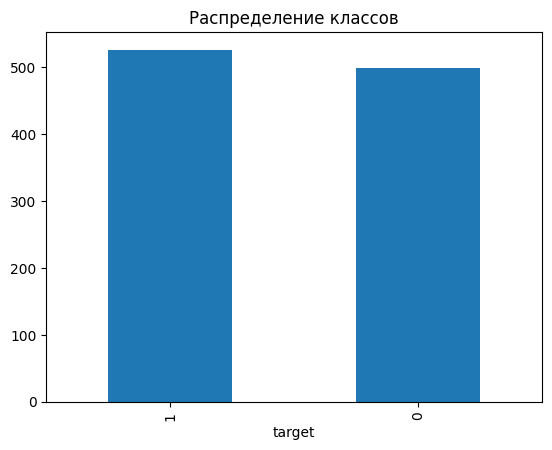

In [ ]:
df.head()
df.describe()

class_counts = df['target'].value_counts()
print(class_counts)

# Визуализация
import matplotlib.pyplot as plt
class_counts.plot(kind='bar')
plt.title('Распределение классов')
plt.show()


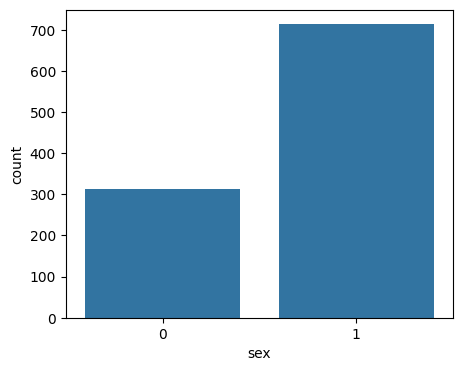

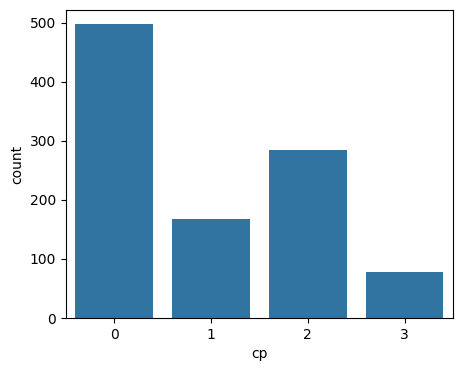

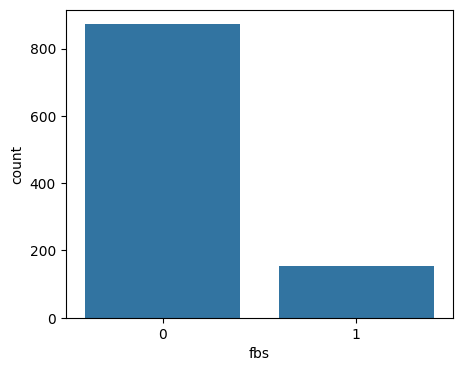

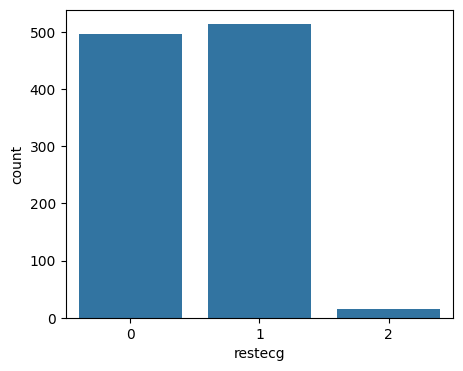

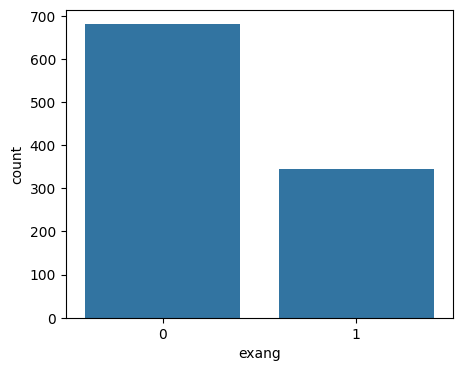

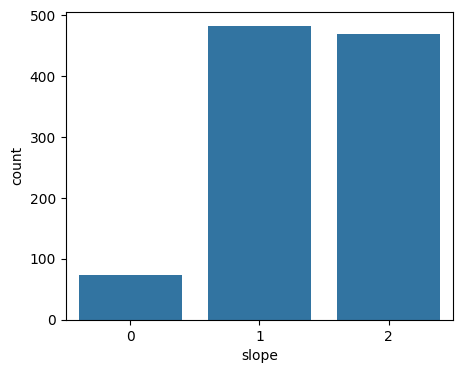

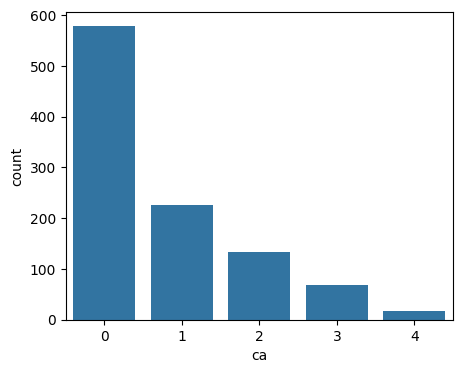

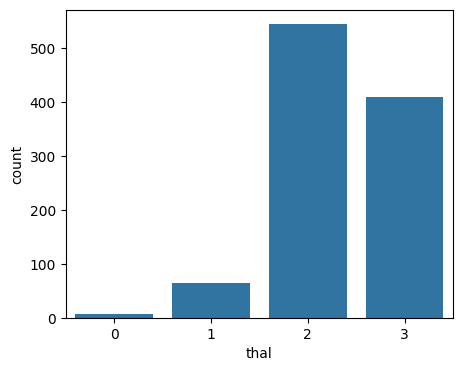

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns #Библиотека поверх matplotlib

categorial_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

for col in categorial_cols:
  plt.figure(figsize=(5,4))
  sns.countplot(x=col, data=df)


Используем pytorch для стандартизации дискретных значений

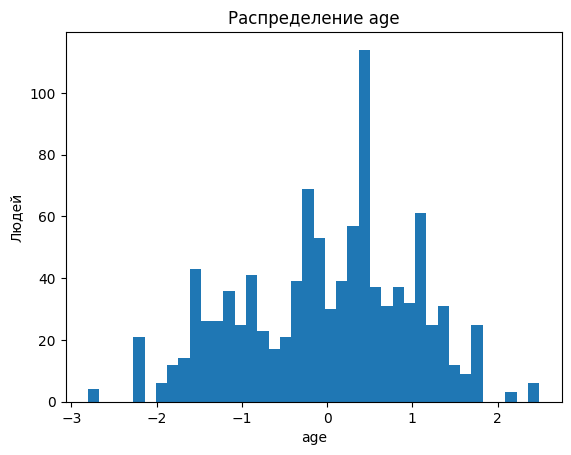

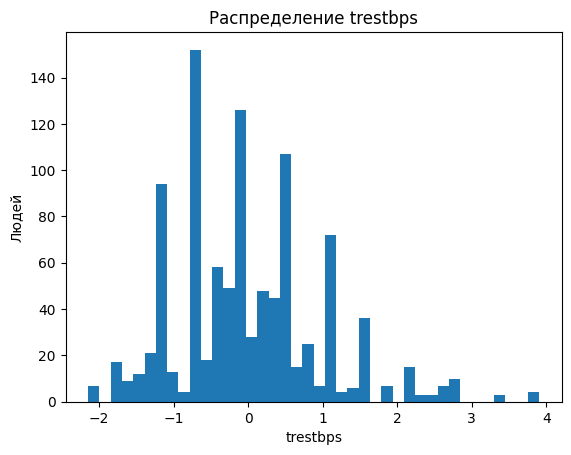

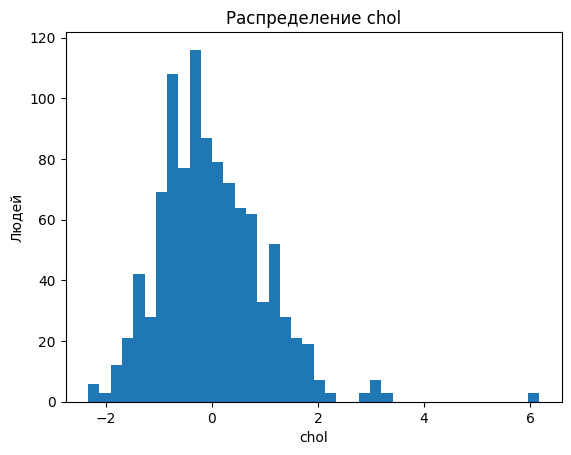

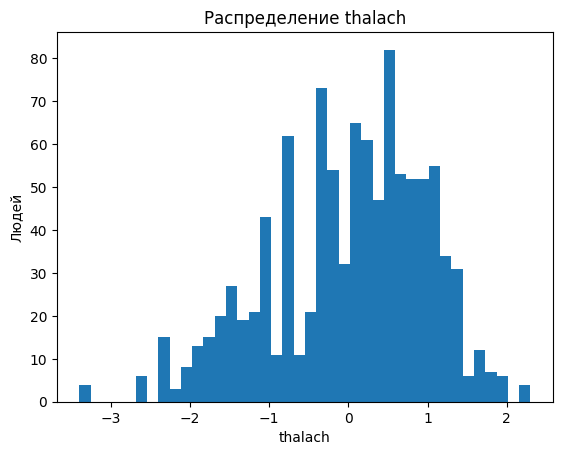

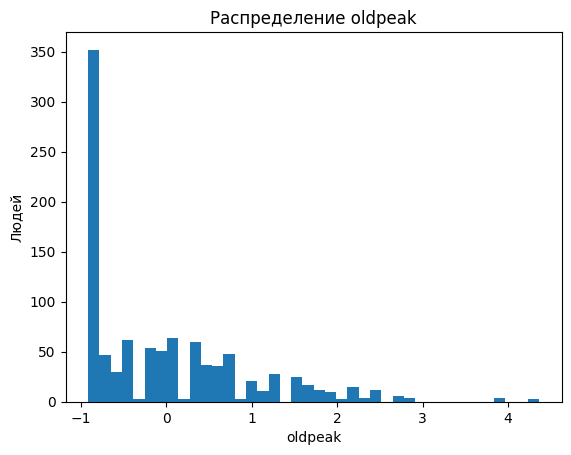

In [ ]:
import torch, numpy
uncategorial_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

X_tensor = torch.tensor(df[uncategorial_cols].values).float()
means = X_tensor.mean(dim=0, keepdim=True)
stds = X_tensor.std(dim=0, keepdim=True)

X_scaled = (X_tensor - means) / stds


for i, col in enumerate(uncategorial_cols):
  data = X_scaled[:, i].numpy()
  plt.xlabel(f'{col}')
  plt.ylabel(f'Людей')
  plt.hist(data, bins=40)

  plt.title(f'Распределение {col}')
  plt.show()



Собираем данные в один dataframe

In [ ]:
df_cat_encoded = pd.get_dummies(df[categorial_cols].astype(str), drop_first=True)
X_scaled_df = pd.DataFrame(X_scaled.numpy(), columns=uncategorial_cols)
X_full = pd.concat([X_scaled_df, df_cat_encoded], axis=1)
target_col = ['target']
y = df[target_col].values

X_full = X_full.astype(float)


Создадим модель и датасет

In [ ]:
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset, Subset

class Model(nn.Module):
    def __init__(self, dropout, neurons_layer1, neurons_layer2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=X_full.shape[1], out_features=neurons_layer1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(neurons_layer1, neurons_layer2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(neurons_layer2, 1),
            nn.Sigmoid()
        ).to(device)

    def forward(self, x):
        return self.model(x)


class HeartDataset(Dataset):
  def __init__(self, data, labels):
    self.data = torch.tensor(data.values).float()
    self.labels = torch.tensor(labels).float()

  def __getitem__(self, index):
    return self.data[index], self.labels[index]

  def __len__(self):
    return len(self.data)


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu' # Датасет небольшой. Скорость работы быстрее на cpu, чем на gpu/tpu
study = None

Воспользуемся подбором гиперпараметров Optuna

In [ ]:
!pip3 install optuna
import optuna
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from torch.utils.data import Subset, DataLoader, Dataset #subset для выборки части датасета по заданным индексам


# Определение функции для тренировки и валидации модели
def objective(trial):
    # Настройка гиперпараметров
    neurons_layer1 = trial.suggest_int('neurons_layer1', 16, 128)  # Количество нейронов в первом слое
    neurons_layer2 = trial.suggest_int('neurons_layer2', 8, 64)    # Количество нейронов во втором слое
    dropout = trial.suggest_uniform('dropout', 0.2, 0.5)           # Dropout от 0.2 до 0.5
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)                # Логарифмический выбор learning rate
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64]) # Категориальный выбор размера выборки
    kfold_splits = trial.suggest_int('kfold_splits', 4, 12)        # Размер делений kfold

    trial_start = time.time()

    # Возвращаем accuracy для Optuna
    result = model_Training(neurons_layer1, neurons_layer2, dropout, lr,
                   batch_size, kfold_splits)
    print(f"\n✅ Trial {trial.number} завершён за {time.time()-trial_start:.2f} сек")

    return result

def model_Training(neurons_layer1, neurons_layer2, dropout,
                   lr, batch_size, kfold_splits):



    kfold = StratifiedKFold(n_splits=kfold_splits, shuffle=True)
    start_time = time.time()

    val_accs = []
    time_ = []
    total_fold_time = 0  # Для сбора общей статистики

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_full, y)):
        fold_start = time.time()

        print(f"\n🌀 Fold {fold+1}/{kfold_splits} начат...")

        # Создаем модель с гиперпараметрами из Optuna
        model = Model(dropout, neurons_layer1, neurons_layer2).to(device)

        # Оптимизатор с L2-регуляризацией (weight_decay)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        crit = nn.BCELoss().to(device)


        #make a dataloader
        train_dl = DataLoader(
            HeartDataset(X_full.iloc[train_idx], y[train_idx]),
            batch_size=batch_size,
            shuffle=True,
            pin_memory=True)

        val_dl = DataLoader(
            HeartDataset(X_full.iloc[val_idx], y[val_idx]),
            batch_size=batch_size,
            pin_memory=True)

        # Тренировка
        model.train()
        for epoch in range(10):
            for xb, yb in train_dl:
                xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
                optimizer.zero_grad()
                pred = model(xb)
                loss = crit(pred, yb)
                loss.backward()
                optimizer.step()

        # Валидация
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)

                pred = model(xb)
                prediction = (pred > 0.5).float()
                # Переносим результаты на CPU для sklearn
                y_true.extend(yb.cpu().numpy())
                y_pred.extend(prediction.cpu().numpy().flatten())

        # Рассчитываем метрики
        acc = accuracy_score(y_true, y_pred)
        # precision = precision_score(y_true, y_pred)
        # recall = recall_score(y_true, y_pred)
        # f1 = f1_score(y_true, y_pred)


        val_accs.append(acc)

        fold_time = time.time() - fold_start
        total_fold_time += fold_time
        print(f"⏱️ Fold {fold+1} завершён за {fold_time:.2f} сек | Точность: {acc:.4f}")
    return sum(val_accs)/len(val_accs) #accuracy




In [ ]:
# Оптимизация гиперпараметров с помощью Optuna
time_ = time.time()
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')  # Цель - максимизация accuracy
study.optimize(objective, n_trials=15, n_jobs=1)
print(f"Весь optuna выполнен за: {time.time()-time_:.2f}")

print(f"Best hyperparameters: {study.best_params}")


# Весь optuna выполнен за: 102.79 - gpu
# Весь optuna выполнен за: 78.42 - cpu
# Trial 32 finished with value: 0.974623803009576 and parameters: {'neurons_layer1': 123, 'neurons_layer2': 31, 'dropout': 0.22125162836853784, 'lr': 0.011898235544978132, 'batch_size': 64, 'kfold_splits': 12}. Best is trial 32 with value: 0.974623803009576.


Тренировка модели.

Формируем тестовые и валидационные данные, используя k-fold cross-validation
(Обучение k раз при k равных частях данных)


In [ ]:
train_loss = []
train_acc = []
val_accs = []
val_loss = []
time_ = []
all_metrics = []
best_rec = None

#Выбираем лучшие параметры, которые смогли подобрать
if study is None: # Уже подобранные параметры, acc = 97%
  neurons_layer1 = 123
  neurons_layer2 = 31
  dropout = 0.22125162836853784
  batch_size = 64
  lr = 0.011898235544978132
  kfold_splits = 12
else:  # Параметры, которые только что добыли при помощи optuna
  neurons_layer1 = study.best_params['neurons_layer1']
  neurons_layer2 = study.best_params['neurons_layer2']
  dropout = study.best_params['dropout']
  batch_size = study.best_params['batch_size']
  lr = study.best_params['lr']
  kfold_splits = study.best_params['kfold_splits']





📁 Fold 1
  Fold 1 завершён за 4.91 сек

Accuracy: 0.9884, Precision: 1.0000, Recall: 0.9773, F1: 0.9885
📁 Fold 2
  Fold 2 завершён за 1.57 сек

Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Model saved. Fold: 2; Val: 1.0000
📁 Fold 3
  Fold 3 завершён за 2.76 сек

Accuracy: 0.9767, Precision: 0.9773, Recall: 0.9773, F1: 0.9773
📁 Fold 4
  Fold 4 завершён за 2.32 сек

Accuracy: 0.9651, Precision: 0.9556, Recall: 0.9773, F1: 0.9663
📁 Fold 5
  Fold 5 завершён за 1.34 сек

Accuracy: 0.9535, Precision: 0.9348, Recall: 0.9773, F1: 0.9556
📁 Fold 6
  Fold 6 завершён за 1.50 сек

Accuracy: 0.9529, Precision: 0.9149, Recall: 1.0000, F1: 0.9556
📁 Fold 7
  Fold 7 завершён за 1.53 сек

Accuracy: 0.9294, Precision: 0.9302, Recall: 0.9302, F1: 0.9302
📁 Fold 8
  Fold 8 завершён за 1.24 сек

Accuracy: 0.9294, Precision: 0.9130, Recall: 0.9545, F1: 0.9333
📁 Fold 9
  Fold 9 завершён за 0.99 сек

Accuracy: 0.9529, Precision: 1.0000, Recall: 0.9091, F1: 0.9524
📁 Fold 10
  Fold 10 завершён з

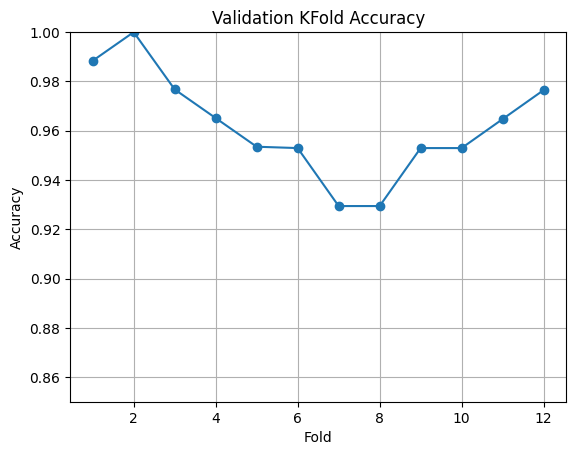

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from torch.utils.data import Subset, DataLoader, Dataset #subset для выборки части датасета по заданным индексам
import matplotlib.pyplot as plt
import time
import sys




kfold = StratifiedKFold(n_splits=kfold_splits, shuffle=True) #Сохраняет пропорции классов ('target') в каждом фолде
start_time = time.time()

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_full, y)):
    print(f'📁 Fold {fold + 1}')
    t0 = time.time()



    train_dl = DataLoader(
        HeartDataset(X_full.iloc[train_idx], y[train_idx]),
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True)

    val_dl = DataLoader(
        HeartDataset(X_full.iloc[val_idx], y[val_idx]),
        batch_size=batch_size,
        pin_memory=True)


    model = Model(dropout, neurons_layer1, neurons_layer2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    crit = nn.BCELoss().to(device)


    #Тренировка
    model.train()
    for epoch in range(10):
      for xb, yb in train_dl:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        optimizer.zero_grad()
        pred = model(xb)
        loss = crit(pred, yb)
        loss.backward()
        optimizer.step()

    #Валидация модели
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
      for xb, yb in val_dl:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb)
        prediction = (pred > 0.5).float()
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(prediction.cpu().numpy().flatten())

    elapsed = time.time() - t0
    time_.append(elapsed)
    print(f"  Fold {fold + 1} завершён за {elapsed:.2f} сек\n")

    acc = accuracy_score(y_true, y_pred)    # Accuracy = (TP + TN) / (TP + TN + FP + FN)
    prec = precision_score(y_true, y_pred)  # Precision = TP / (TP + FP)
    rec = recall_score(y_true, y_pred)      # Recall = TP / (TP + FN)
    f1 = f1_score(y_true, y_pred)           # F1 = 2 * (Precision * Recall) / (Precision + Recall)

    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

    val_accs.append(acc)

    if best_rec is None:
      best_rec = rec

    if best_rec < rec:
      best_rec = rec

      torch.save(model.state_dict(), f'model_state_dict_fold.pt')
      # torch.save(model.state_dict(), f'model_state_dict_fold_{fold + 1}.pt')
      print(f'Model saved. Fold: {fold + 1}; Val: {best_rec:.4f}')




total_time = time.time() - start_time
print(f"\n  Всё обучение завершено за {total_time:.2f} секунд")
print(f"  Среднее время обучения: {sum(time_)/len(time_):.2f} сек")


print(f"Highest validation accuracy: {max(val_accs):.4f}:")
print(f"Medium validation accuracy: {sum(val_accs)/len(val_accs):.4f}")
print(f"Lowest validation accuracy: {min(val_accs):.4f}")

plt.plot(range(1, kfold_splits+1), val_accs, marker='o')
plt.title('Validation KFold Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0.85, 1.0)
plt.grid(True)
plt.show()